In [304]:
from IPython.display import HTML 
s="""<h1>Lax-Friedrichs, Lax-Wendroff, MacCormack and Beam-Warming Schemes</h1></br><div id="toc"></div>
<script src="https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js" defer></script>""";
h=HTML(s); h

# Understand the Problem

## Question

* What is the 1D velocity for the **1D Burgers Equation** for flow with a step function for the initial conditions?
* Invesgiate the propagation with the:

    1. LF
    2. LW
    3. MacCormack


* $\Delta x$ = $\Delta t$  = 0.1
* Change ${{\Delta t} \over {\Delta x}} $from 1 to 0.5 (effect of Courant Number)
* Change to a finer mesh (effect of step sizes)

## Initial Conditions

* `t = 0s` and `x = 0m to 2m` $\Rightarrow$ ` u = 1m/s`

* `t = 0s` and `x = 2m to 4m` $\Rightarrow$ `u = 0m/s`

## Boundary Conditions

* `x = 0m` $\Rightarrow$ ` u = 1m/s`

* `y = 2m` $\Rightarrow$ ` u = 0m/s`

## Governing Equation

* The Burgers Equation is a wave that propagates with different speeds at different points in the solution
* Eventually a shock will be formed

* In **Non-conservative Form** the Burgers Equation is described as follows:

$$ {\partial u \over \partial t} + u {\partial u \over \partial x} = 0 $$

Non-conservative form will not be good at resolving problems with **sharp changes**. 

* In **Conservative Form** the Burgers Equation is described as follows (for the derivation see http://www.thevisualroom.com/conservative_form.html)

$$ {\partial u \over \partial t} + {\partial \over {\partial x}}{ \left( {u^2 \over 2} \right)} = 0 $$

Alternatively, one can write this:

$$ {\partial u \over \partial t} + {\partial F \over {\partial x}} = 0 $$

where flux:

$$ F = {{u^2} \over 2} $$

***

# Formulate the Problem

## Input Data:

Burgers Equation **does have a temporal component**, so we use `nt`

* `nt` = ? (number of temporal points)
* `nx` = 51 (number of x spatial points)
* `tmax` = 1.0
* `xmax` = 4.0

Formulate `nt` based on the CFL Condition `sigma = (dt / dx) = 1`

## Initial Conditions:

* $\forall (x, t) \quad t = 0 \land x \le 2 \rightarrow u(x,0) = 2 $
* $\forall (x, t) \quad t = 0 \land x \gt 2 \rightarrow u(x,0) = 0 $

## Velocity Boundary Conditions:

* $\forall (x, t) \quad x = 0 \rightarrow u(0,t) = 2 $
* $\forall (x, t) \quad x = 4 \rightarrow u(4,t) = 0 $

## Output Data:

* $\forall (x, t) \quad \ u(x,t) = ? $

***



# Design Algorithm to Solve Problem using Lax-Friedrichs Scheme

## Space-time discretisation:

* i $\rightarrow$ index of grid in x
* n $\rightarrow$ index of time

## Lax-Friedrichs Numerical scheme

* For the **one** first derivative of **velocity** in time: 1st order FD in time
* For the **one** first derivative of **flux** in space: 2nd order CD in space
* Replace $u_i^n = {1 \over 2} (u_{i+1}^n+u_{i-1}^n)$

## Discrete equation

$$ {{u_i^{n+1} - {1 \over 2}(u_{i+1}^n+u_{i-1}^n)} \over {\Delta t}} + {{F_{i+1}^n - F_{i-1}^n} \over {2 \Delta x}}=0 $$

## Transpose

$$ u_i^{n+1} = {1 \over 2} (u_{i-1}^n + u_{i+1}^n) - {\sigma \over 2} (F_{i+1}^n - F_{i-1}^n) $$

## Pseudo-code

       #Constants
       xmax = 4.0
       nx = 51
       dx = xmax/(nx-1)
       tmax = 1.0
       sigma = 1.0
       dt =  dx * sigma
       nt = int(tmax/dt + 1)
       
       #Boundary Conditions
       for n between 0 and nt-1
          u(0,n)=1
          u(nx-1,n)=0 

       #Initial Conditions
       for i between 1 and nx-2
          if(i < (nx-1)/2)
              u(i,0) = 1
          else
              u(i,0) = 0
       
       F = (u/2)**2
       
       #Iteration
       for n between 0 and nt-1
          for i between 1 and nx-2
              u(i,n+1) = 0.5*[ u(i-1,n)+u(i+1,n) ] - 0.5*sigma*[ F(i+1,n)-F(i-1,n) ]

In [5]:
def initial_and_boundary_conditions(nx, nt):
    
    # Initialise data structures
    import numpy as np
    u = np.zeros((nx,nt))
    
    # Boundary conditions
    u[0,:] = 1.0
    u[nx-1,:] = 0.0

    half = int((nx-1)/2)

    # Initial conditions      
    u[0:half,0] = 1.0
    
    return u

In [130]:
def initial_and_boundary_conditions_2(nx, nt):
    
    # Initialise data structures
    import numpy as np
    u = np.zeros((nx,nt))
    
    # Boundary conditions
    u[0,:] = 1.1
    u[nx-1,:] = 0.0

    half = int((nx-1)/2)

    # Initial conditions      
    u[0:half,0] = 1.1
    
    return u

In [3]:
def analytical(nx, tmax, xmax):
    """
    Returns the velocity field and distance for 1D non-linear convection
    This is just transporting the ICs with a Courant number of 2 
    (effectively a numerical wave speed of 0.5)
    """
    
    # Increments
    # dx = xmax/(nx-1)
    # dt = dx*sigma
    # tmax = (nt-1)*dt

    dx = xmax/(nx-1)
    dt = dx/0.5
    nt = int((tmax/dt)+1)
    
    # Initial and Boundary Conditions
    u = initial_and_boundary_conditions(nx, nt)

    # X Loop
    x = np.zeros(nx)
    x = np.linspace(0.0,xmax,nx)
    
    i = 1
    # Loop - must loop as NumPy cannot be used for dependency reasons
    for n in range(0,int(nt-1)):
        u[i:nx-1, n+1] = u[i-1:nx-2, n]

    return u, x, nt

In [1]:
def analytical_2(nx, tmax, xmax):
    """
    Returns the velocity field and distance for 1D non-linear convection
    This is just transporting the ICs with a Courant number of 2 
    (effectively a numerical wave speed of 0.5)
    """
    
    # Increments
    # dx = xmax/(nx-1)
    # dt = dx*sigma
    # tmax = (nt-1)*dt

    dx = xmax/(nx-1)
    dt =  dx / (((1.1+0.0)/2.0))
    nt = int(tmax/dt + 1)
    
    # Initial and Boundary Conditions
    u = initial_and_boundary_conditions_2(nx, nt)

    # X Loop
    x = np.zeros(nx)
    x = np.linspace(0.0,xmax,nx)
    
    i = 1
    # Loop - must loop as NumPy cannot be used for dependency reasons
    for n in range(0,int(nt-1)):
        u[i:nx-1, n+1] = u[i-1:nx-2, n]

    return u, x, nt

In [215]:
def plot(u,x,NT,u_analytical, x_analytical, NT2, step, dt, dt_lf):
      """
      Plots the 1D velocity field
      """

      import matplotlib.pyplot as plt
      import matplotlib.cm as cm
      plt.figure()
      ax=plt.subplot(111)
      colour=iter(cm.rainbow(np.linspace(0,step,NT)))   
      for n in range(0,NT,step):
         t = n*dt
         c=next(colour)
         ax.plot(x,u[:,n],linestyle='-',c=c,label='t='+str(t))
      t_lf =(NT2-1)*dt_lf      
      ax.plot(x_analytical,u_analytical[:,NT2-1],linestyle='--',c='k',label='t='+str(t_lf)+' analytical')   
      box=ax.get_position()
      ax.set_position([box.x0, box.y0, box.width*2,box.height*2])
      ax.legend( bbox_to_anchor=(1.02,1), loc=2)
      plt.ylim([-0.5,1.5])
      plt.xlim([0.0,4.0])
      plt.xlabel('x (m)')
      plt.ylabel('u (m/s)')
      plt.show()


In [2]:
def lax_friedrichs_convection(sigma, nx, nt, xmax, step):
    """
    Returns the velocity field and distance for 1D linear convection
    """

    # Increments
    # dx = xmax/(nx-1)
    # dt = dx*sigma
    # tmax = (nt-1)*dt
    dx = xmax/(nx-1)
    dt =  dx * sigma
    nt = int(tmax/dt + 1)

    # Initial and Boundary Conditions
    u = initial_and_boundary_conditions(nx, nt)

    # X Loop
    x = np.zeros(nx)
    x = np.linspace(0.0,xmax,nx)

    # Lambda function for Flux:
    F = lambda u: u**2.0 / 2.0   

    i = 1
    # Loop - must loop as NumPy cannot be used for dependency reasons
    for n in range(0,int(nt-1)):
        u[i:nx-1, n+1] = (0.5*(u[i-1:nx-2, n]+u[i+1:nx, n])-
                         0.5*sigma*(F(u[i+1:nx, n])-F(u[i-1:nx-2, n])))

    # Lax-Friedrichs with Courant Number = 2
    u_lf, x_lf, nt_lf = analytical(nx, tmax, xmax)

    dt_lf = dx * 2.0

    plot(u,x,nt,u_lf, x_lf, nt_lf, step, dt, dt_lf)

In [103]:
def plot_cfl(x,u_1,nt_1,u_2,nt_2,u_3,nt_3,u_lf, x_lf, nt_lf, dt_1, dt_2, dt_3, dt_lf):
      """
      Plots the 1D velocity field
      """

      import matplotlib.pyplot as plt
      import matplotlib.cm as cm
      plt.figure()
      ax=plt.subplot(111)
      c_1 = dt_1/(max(x)/100)
      c_2 = dt_2/(max(x)/100)
      c_3 = dt_3/(max(x)/100)
      t_1 =(nt_1-1)*dt_1      
      ax.plot(x,u_1[:,nt_1-1],linestyle='-',c='r',label='t='+str(t_1)+' Courant = '+str(c_1))
      t_2 =(nt_2-1)*dt_2      
      ax.plot(x,u_2[:,nt_2-1],linestyle='-',c='b',label='t='+str(t_2)+' Courant = ' +str(c_2))
      t_3 =(nt_3-1)*dt_3      
      ax.plot(x,u_3[:,nt_3-1],linestyle='-',c='g',label='t='+str(t_3)+' Courant = ' +str(c_3))   
            
      t_lf =(nt_lf-1)*dt_lf      
      ax.plot(x_lf,u_lf[:,nt_lf-1],linestyle='--',c='k',label='t='+str(t_lf)+' Analytical')   
      box=ax.get_position()
      ax.set_position([box.x0, box.y0, box.width*2,box.height*2])
      ax.legend( bbox_to_anchor=(1.02,1), loc=2)
      plt.ylim([-0.5,1.5])
      plt.xlim([0.0,4.0])
      plt.xlabel('x (m)')
      plt.ylabel('u (m/s)')
      plt.show()


In [177]:
def lax_friedrichs_convection_cfl(sigma_1, sigma_2, sigma_3, nx, tmax, xmax):
    """
    Returns the velocity field and distance for 1D linear convection
    """
    # Increments
    dx = xmax/(nx-1)
    dt_1 =  dx * sigma_1
    nt_1 = int(tmax/dt_1 + 1)
    dt_2 =  dx * sigma_2
    nt_2 = int(tmax/dt_2 + 1)
    dt_3 =  dx * sigma_3
    nt_3 = int(tmax/dt_3 + 1)
    
    # Initial and Boundary Conditions
    u_1 = initial_and_boundary_conditions(nx, nt_1)
    u_2 = initial_and_boundary_conditions(nx, nt_2)
    u_3 = initial_and_boundary_conditions(nx, nt_3)

    # X Loop
    x = np.zeros(nx)
    x = np.linspace(0.0,xmax,nx)

    # Lambda function for Flux:
    F = lambda u: u**2.0 / 2.0   
    
    i = 1
    # Loop - must loop as NumPy cannot be used for dependency reasons
    for n in range(0,nt_1-1):
        u_1[i:nx-1, n+1] = (0.5*(u_1[i-1:nx-2, n]+u_1[i+1:nx, n])-
                         0.5*sigma_1*(F(u_1[i+1:nx, n])-F(u_1[i-1:nx-2, n])))
        
    for n in range(0,nt_2-1):
        u_2[i:nx-1, n+1] = (0.5*(u_2[i-1:nx-2, n]+u_2[i+1:nx, n])-
                     0.5*sigma_2*(F(u_2[i+1:nx, n])-F(u_2[i-1:nx-2, n])))
        
    for n in range(0,nt_3-1):
        u_3[i:nx-1, n+1] = (0.5*(u_3[i-1:nx-2, n]+u_3[i+1:nx, n])-
             0.5*sigma_3*(F(u_3[i+1:nx, n])-F(u_3[i-1:nx-2, n])))
        
    # Lax-Friedrichs with Courant Number = 2
    u_lf, x_lf, nt_lf = analytical(nx, tmax, xmax)
    
    dt_lf = dx * 2.0
    
    plot_cfl(x,u_1,nt_1,u_2,nt_2,u_3,nt_3,u_lf, x_lf, nt_lf, dt_1, dt_2, dt_3, dt_lf)

In [178]:
def lax_friedrichs_convection_initial(sigma_1, sigma_2, sigma_3, nx, tmax, xmax):
    """
    Returns the velocity field and distance for 1D linear convection
    """
    # Increments
    dx = xmax/(nx-1)
    dt_1 =  dx * sigma_1
    nt_1 = int(tmax/dt_1 + 1)
    dt_2 =  dx * sigma_2
    nt_2 = int(tmax/dt_2 + 1)
    dt_3 =  dx * sigma_3
    nt_3 = int(tmax/dt_3 + 1)
    
    # Initial and Boundary Conditions
    u_1 = initial_and_boundary_conditions_2(nx, nt_1)
    u_2 = initial_and_boundary_conditions_2(nx, nt_2)
    u_3 = initial_and_boundary_conditions_2(nx, nt_3)

    # X Loop
    x = np.zeros(nx)
    x = np.linspace(0.0,xmax,nx)

    # Lambda function for Flux:
    F = lambda u: u**2.0 / 2.0   
    
    i = 1
    # Loop - must loop as NumPy cannot be used for dependency reasons
    for n in range(0,nt_1-1):
        u_1[i:nx-1, n+1] = (0.5*(u_1[i-1:nx-2, n]+u_1[i+1:nx, n])-
                         0.5*sigma_1*(F(u_1[i+1:nx, n])-F(u_1[i-1:nx-2, n])))
        
    for n in range(0,nt_2-1):
        u_2[i:nx-1, n+1] = (0.5*(u_2[i-1:nx-2, n]+u_2[i+1:nx, n])-
                     0.5*sigma_2*(F(u_2[i+1:nx, n])-F(u_2[i-1:nx-2, n])))
        
    for n in range(0,nt_3-1):
        u_3[i:nx-1, n+1] = (0.5*(u_3[i-1:nx-2, n]+u_3[i+1:nx, n])-
             0.5*sigma_3*(F(u_3[i+1:nx, n])-F(u_3[i-1:nx-2, n])))
        
    # Passing ICs with Courant Number = 2
    u_lf, x_lf, nt_lf = analytical_2(nx, tmax, xmax)
    
    dt_lf = dx * 2.0
    
    plot_cfl(x,u_1,nt_1,u_2,nt_2,u_3,nt_3,u_lf, x_lf, nt_lf, dt_1, dt_2, dt_3, dt_lf)

## Lax-Friedrichs CFL Number = 0.5

Stability condition:

$$ \left| {\Delta t \over \Delta x} u_{max} \right| \lt 1 $$

Where $ u_{max} $ is the maximum eigenvalue of the A matrix

$$ \left| u \right| \le {\Delta x \over \Delta t} $$

Meaning of $ {\Delta x \over \Delta t} $ is the **velocity of the computated information**, i.e. $1 \over \sigma$, so this must be greater than or equal to **the velocity of the physical wave**.

The effective wave speed is $c = {{u_R + u_L} \over 2} = 0.5 $ **this is not a stability condition - due to the condition of needing to resolve a wave of length** $2 \Delta x$

Lax-Friedichs also adds an artificial diffusion term $({\Delta x^2 \over \Delta t}) {\partial^2 Q \over \partial x^2}$ with an artificial viscosity of 0.5 to the RHS of the FTCS scheme, to stabilize it using standard second order central differencing for the diffusion term

However, this scheme is still **first order**. The shock is subject to numerical dissipation

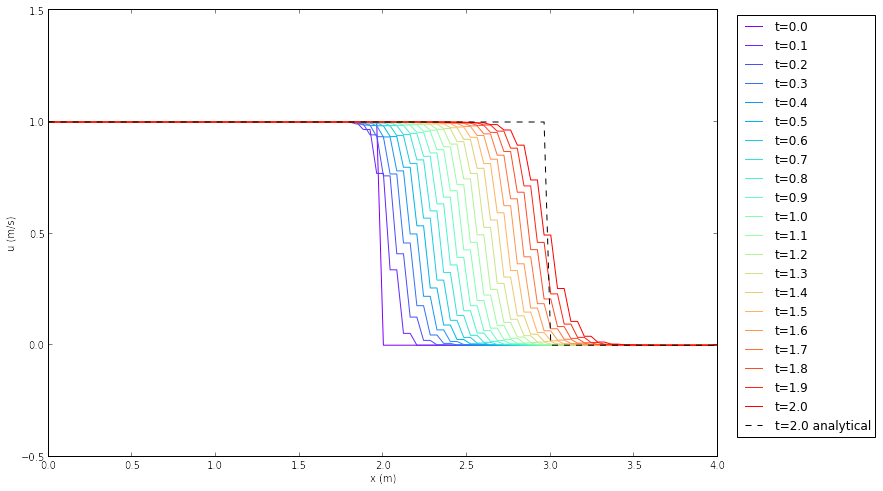

In [172]:
lax_friedrichs_convection(0.5, 101, 2.0, 4.0, 5)

## Lax-Friedrichs CFL Number = 1, 0.5 and 0.25

* CFL Number effectively reduced the timestep, increasing the number of timesteps
* The numerical diffusion is proportional to the number of timesteps, so that increasing the **CFL number increases the numerical dissipation**

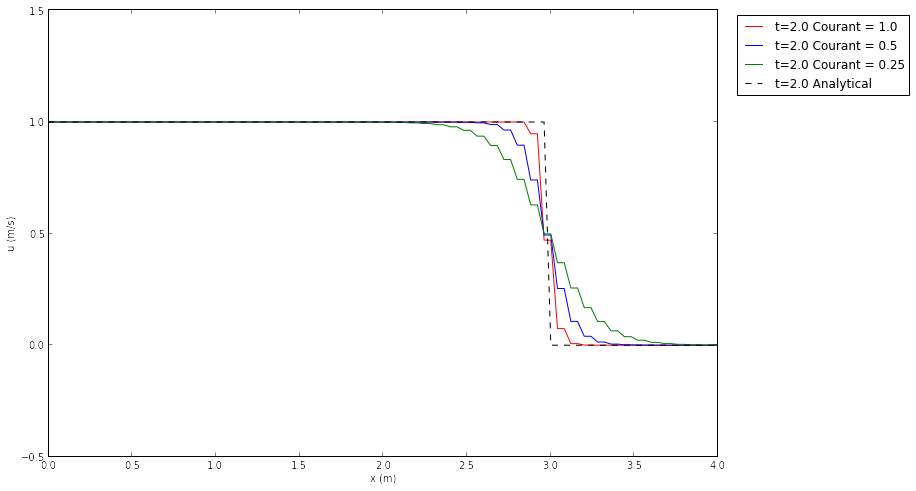

In [180]:
lax_friedrichs_convection_cfl(1.0, 0.5, 0.25, 101, 2.0, 4.0)

## Lax-Friedrichs CFL Number = 1, 1.28, 2

* CFL above 1, the solution should be unstable
* However, CFL of 2 **appears** stable

### Why is CFL = 2 stable for Lax-Friedrichs?

#### Explanation from Linear Convection

$$ {\partial u \over \partial t} = -c {\partial u \over \partial x} $$

With FTBS:

$$ {{u_i^{n+1} - u_i^n} \over \Delta t} = -c\left( {{u_i^n - u_{i-1}^n} \over \Delta x} \right)$$

i.e.

$$ u_i^{n+1} = u_i^n -\sigma \left( {{u_i^n - u_{i-1}^n}} \right)$$

With $\sigma = 1$:

$$ u_i^{n+1} = u_{i-1}^n$$

i.e. the new value in time equals the upstream value - just propagating the **Initial Conditions** through the domain

#### Explanation from Non-Linear Convection

$$ u_i^{n+1} = {1 \over 2} (u_{i+1}^n + u_{i-1}^n)-{\sigma \over 2} \left( {{(u_{i+1}^n)^2 \over 2} - {(u_{i-1}^n)^2 \over 2}} \right)$$

At the shock and $\sigma = 2$

$$u_{i+1}^n = 0$$
$$u_{i-1}^n = 1$$

$$ u_i^{n+1} = {1 \over 2} (0+1)-{2 \over 2} \left( 0 -{1 \over 2} \right) = 1$$

i.e. the new value equals the upstream value - similar to CFL = 1 for FTBS (upwind)

**It's simply a cancellation of terms**

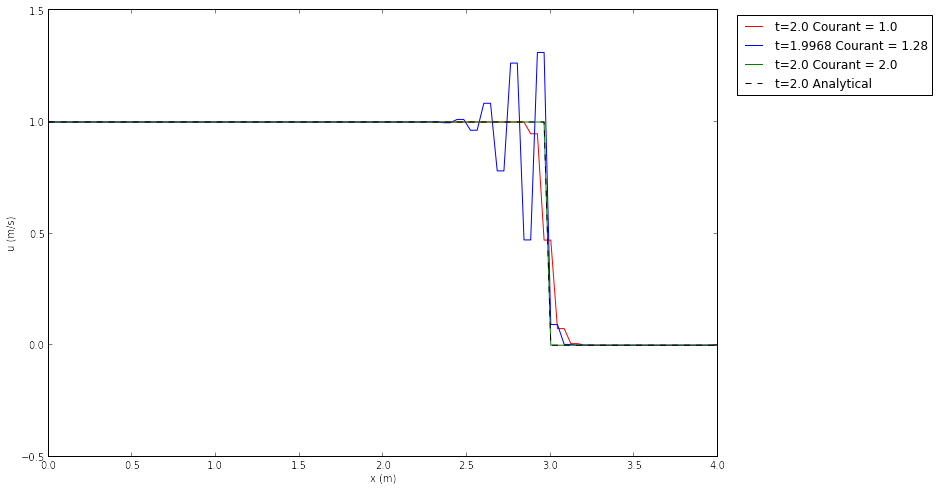

In [181]:
lax_friedrichs_convection_cfl(1.0, 1.28, 2.0, 101, 2.0, 4.0)

### CFL=2 numerical cancellation of terms for Lax-Friedrichs is not generally applicable and depends on the ICs+BCs

* This shows for ICs with a slightly higher value, the Courant Number needs to be less than 1 for stability (as it should)


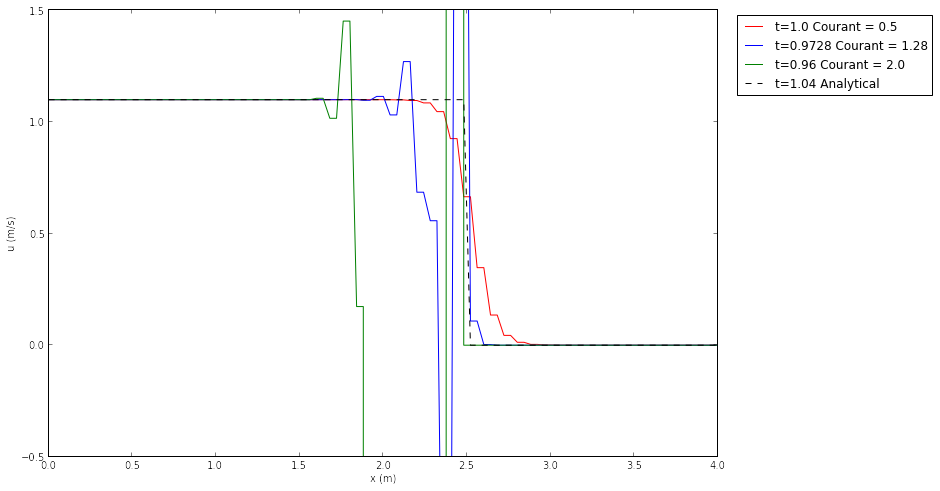

In [186]:
lax_friedrichs_convection_initial(0.5, 1.28, 2.0, 101, 1.0, 4.0)

## Conclusion from Lax-Friedrichs

Lax-Friedrichs shows **diffusion error** (acculumated numerical diffusion)

* Reducing the CFL number reduces the timestep
* Reducing the timestep increases the number of iterations to get to the same point in time
* The diffusion error is proportional to (amplitude ratio) to the power of number of timesteps 
* Therefore increasing the number of timesteps increases the diffusion error

Lax-Friedrichs has best accuracy with **CFL = 1**

Lax Friedrichs shows **Odd-Even Decoupling**:

1) The value of the velocity at point $u_i^{n+1}$ does not depend on the value at $u_i^n$. 

2) Since $u_i^n$ depends on $u_{i-1}^{n-1}$ and $u_{i+1}^{n-1}$, then $u_i^{n+1}$ does not depend on these either

This is similar to the behavior of a collocated grid when pressure and velocity are decoupled. 

# Design Algorithm to Solve Problem using Lax-Wendroff Scheme

## Space-time discretisation:

* i $\rightarrow$ index of grid in x
* n $\rightarrow$ index of time

## Conservative Form

$$ {\partial u \over \partial t} + {\partial \over {\partial x}}{ \left( {u^2 \over 2} \right)} = 0 \qquad
   \Leftrightarrow \qquad {\partial u \over \partial t} + {{\partial F} \over {\partial x}} = 0$$
   
## Non-Conservative Form

$$ {\partial u \over \partial t} + u {{\partial u} \over {\partial x}} = 0 \qquad
   \Leftrightarrow \qquad {\partial u \over \partial t} + A {{\partial u} \over {\partial x}} = 0$$
   
* F = Flux for Conservative Form of Burgers Equation
* A = Jacobian for Non-Conservative Form of Burgers Equation

$$ A = {{\partial F} \over {\partial u}} = u $$

## Lax-Wendroff Numerical scheme

* Taylor Expansion to 2nd order term:

$$ u_i^{n+1} = u_i^n + {\Delta t}(u_t)_i^n + {\Delta t^2 \over 2} (u_{tt})_i^n + O(\Delta t^3) $$


* Replace $u_t$ and $u_{tt}$ by spatial derivatives:

$$ u_t = - F_x $$

$$ u_{tt} = -(F_x)_t = -(F_t)_x $$

$$ {{\partial F} \over {\partial t}} = {{\partial F} \over {\partial u}} {{\partial u} \over {\partial t}} = A (-F_x) = -AF_x $$

Hence:

$$ u_{tt} = (A F_x)_x $$

And:

$$ u_i^{n+1} = u_i^n - {\Delta t}(F_x)_i^n + {\Delta t^2 \over 2} ((A F_x)_x)_i^n $$

* For the first derivative of **Flux** in space: 2nd order CD in space between two points
* For the first derivative of **Jacobian times Derivative of the Flux** in space: 2nd order in space between two midpoints
* For the first derivative of midpoint **Flux** in space: 2nd order in space
* For the value of the **Jacobian** at the midpoint: average value

## Discrete equation

$$ u_i^{n+1} = u_i^n - {{\Delta t}} {(F_{i+1}^n - F_{i-1}^n) \over {2 \Delta x}} + {{\Delta t^2} \over 2} {{(AF_x)_{i+{1 \over 2}}^n - (AF_x)_{i-{1 \over 2}}^n \over {\Delta x}}} $$


$$ {{(AF_x)_{i+{1 \over 2}}^n - (AF_x)_{i-{1 \over 2}}^n \over {\Delta x}}}  = 
{1 \over {\Delta x}}(A_{i+{1 \over 2}}^n{{{F_{i+1}^n - F_i^n} \over {\Delta x} }}) -
{1 \over {\Delta x}}(A_{i-{1 \over 2}}^n{{{F_{i}^n - F_{i-1}^n} \over {\Delta x} }}) = \
{1 \over {\Delta x^2}} \left( A_{i+{1 \over 2}}^n{{ ({F_{i+1}^n - F_i^n}) }} -
A_{i-{1 \over 2}}^n{{ ({F_{i}^n - F_{i-1}^n}) }} \right) = \
{1 \over {\Delta x^2}} \left( {{A_{i+1}^n + A_i^n} \over 2} {{ ({F_{i+1}^n - F_i^n}) }} -
{{A_{i}^n + A_{i-1}^n} \over 2}{{ ({F_{i}^n - F_{i-1}^n}) }} \right) = \
{1 \over {2 \Delta x^2}} \left( {({A_{i+1}^n + A_i^n}) } {{ ({F_{i+1}^n - F_i^n}) }} -
{({A_{i}^n + A_{i-1}^n})}{{ ({F_{i}^n - F_{i-1}^n}) }} \right)$$

Hence:

$$ u_i^{n+1} = u_i^n - {{\Delta t}} {(F_{i+1}^n + F_{i-1}^n) \over {2 \Delta x}} + {\Delta t^2 \over {4 \Delta x^2}} \left( {({A_{i+1}^n + A_i^n}) } {{ ({F_{i+1}^n - F_i^n}) }} -
{({A_{i}^n + A_{i-1}^n})}{{ ({F_{i}^n - F_{i-1}^n}) }} \right) $$

$$ u_i^{n+1} = u_i^n - {{\sigma \over 2}} {(F_{i+1}^n - F_{i-1}^n)} + {\sigma^2 \over {4}} \left( {({A_{i+1}^n + A_i^n}) } {{ ({F_{i+1}^n - F_i^n}) }} -
{({A_{i}^n + A_{i-1}^n})}{{ ({F_{i}^n - F_{i-1}^n}) }} \right) $$

## Pseudo-code

       #Constants
       xmax = 4.0
       nx = 51
       dx = xmax/(nx-1)
       tmax = 1.0
       sigma = 1.0
       dt =  dx * sigma
       nt = int(tmax/dt + 1)
       
       #Boundary Conditions
       for n between 0 and nt-1
          u(0,n)=1
          u(nx-1,n)=0 

       #Initial Conditions
       for i between 1 and nx-2
          if(i < (nx-1)/2)
              u(i,0) = 1
          else
              u(i,0) = 0
       
       F = (u/2)**2
       A = u
       
       #Iteration
       for n between 0 and nt-1
          for i between 1 and nx-2
              u(i,n+1) = u(i,n)-0.5*sigma*[ F(i+1,n)-F(i-1,n) ] + 
                         0.25*(sigma**2)*[ ( A(i+1,n)+A(i,n) )*( F(i+1,n)-F(i,n) )-
                                           ( A(i,n)+A(i-1,n) )*( F(i,n)-F(i-1,n) ) ]

In [ ]:
def lax_wendroff_convection_2(sigma, nx, nt, xmax, step):
    """
    Returns the velocity field and distance for 1D linear convection
    """

    # Increments
   # dx = xmax/(nx-1)
   # dt = dx*sigma
   # tmax = (nt-1)*dt
    dx = xmax/(nx-1)
    dt =  dx * sigma
    nt = int(tmax/dt + 1)

    # Initial and Boundary Conditions
    u = initial_and_boundary_conditions(nx, nt)

    # X Loop
    x = np.zeros(nx)
    x = np.linspace(0.0,xmax,nx)

    # Lambda function for Flux:
    F = lambda u: u**2.0 / 2.0  
    
    # Lamba function for Jacobian:
    A = lambda u: u
    
    i = 1
    # Loop - must loop as NumPy cannot be used for dependency reasons
    for n in range(0,nt-1):
        u[i:nx-1, n+1] = (u[i:nx-1,n] -
                         0.5*sigma*( F(u[i+1:nx, n])-F(u[i-1:nx-2, n]) ) + 
        0.25*(sigma**2)*( ( A(u[i+1:nx, n])+A(u[i:nx-1, n]) )*
                          ( F(u[i+1:nx, n])-F(u[i:nx-1, n]) )-
                          ( A(u[i:nx-1, n])+A(u[i-1:nx-2, n]) )*
                          ( F(u[i:nx-1, n])-F(u[i-1:nx-2, n]) ) ) )

    # Wave propagating with speed 0.5
    u_lf, x_lf, nt_lf = analytical(nx, tmax, xmax)

    dt_lf = dx * 2.0

    plot(u,x,nt,u_lf, x_lf, nt_lf, step, dt, dt_lf)

In [194]:
def lax_wendroff_convection_cfl(sigma_1, sigma_2, sigma_3, nx, tmax, xmax):
    """
    Returns the velocity field and distance for 1D linear convection
    """
    # Increments
    dx = xmax/(nx-1)
    dt_1 =  dx * sigma_1
    nt_1 = int(tmax/dt_1 + 1)
    dt_2 =  dx * sigma_2
    nt_2 = int(tmax/dt_2 + 1)
    dt_3 =  dx * sigma_3
    nt_3 = int(tmax/dt_3 + 1)
    
    # Initial and Boundary Conditions
    u_1 = initial_and_boundary_conditions(nx, nt_1)
    u_2 = initial_and_boundary_conditions(nx, nt_2)
    u_3 = initial_and_boundary_conditions(nx, nt_3)

    # X Loop
    x = np.zeros(nx)
    x = np.linspace(0.0,xmax,nx)

    # Lambda function for Flux:
    F = lambda u: u**2.0 / 2.0 
    
    # Lamba function for Jacobian:
    A = lambda u: u
    
    i = 1
    # Loop - must loop as NumPy cannot be used for dependency reasons
    for n in range(0,nt_1-1):
        u_1[i:nx-1, n+1] = (u_1[i:nx-1,n] -
                         0.5*sigma_1*( F(u_1[i+1:nx, n])-F(u_1[i-1:nx-2, n]) ) + 
        0.25*(sigma_1**2)*( ( A(u_1[i+1:nx, n])+A(u_1[i:nx-1, n]) )*
                          ( F(u_1[i+1:nx, n])-F(u_1[i:nx-1, n]) )-
                          ( A(u_1[i:nx-1, n])+A(u_1[i-1:nx-2, n]) )*
                          ( F(u_1[i:nx-1, n])-F(u_1[i-1:nx-2, n]) ) ) )
     
    for n in range(0,nt_2-1):
        u_2[i:nx-1, n+1] = (u_2[i:nx-1,n] -
                         0.5*sigma_2*( F(u_2[i+1:nx, n])-F(u_2[i-1:nx-2, n]) ) + 
        0.25*(sigma_2**2)*( ( A(u_2[i+1:nx, n])+A(u_2[i:nx-1, n]) )*
                          ( F(u_2[i+1:nx, n])-F(u_2[i:nx-1, n]) )-
                          ( A(u_2[i:nx-1, n])+A(u_2[i-1:nx-2, n]) )*
                          ( F(u_2[i:nx-1, n])-F(u_2[i-1:nx-2, n]) ) ) )    
    
    for n in range(0,nt_3-1):
        u_3[i:nx-1, n+1] = (u_3[i:nx-1,n] -
                         0.5*sigma_3*( F(u_3[i+1:nx, n])-F(u_3[i-1:nx-2, n]) ) + 
        0.25*(sigma_3**2)*( ( A(u_3[i+1:nx, n])+A(u_3[i:nx-1, n]) )*
                          ( F(u_3[i+1:nx, n])-F(u_3[i:nx-1, n]) )-
                          ( A(u_3[i:nx-1, n])+A(u_3[i-1:nx-2, n]) )*
                          ( F(u_3[i:nx-1, n])-F(u_3[i-1:nx-2, n]) ) ) )  
        
    # Wave at speed 0.5
    u_lf, x_lf, nt_lf = analytical(nx, tmax, xmax)
    
    dt_lf = dx * 2.0
    
    plot_cfl(x,u_1,nt_1,u_2,nt_2,u_3,nt_3,u_lf, x_lf, nt_lf, dt_1, dt_2, dt_3, dt_lf)    

## Lax-Wendroff CFL = 0.25, 0.5, 1.0

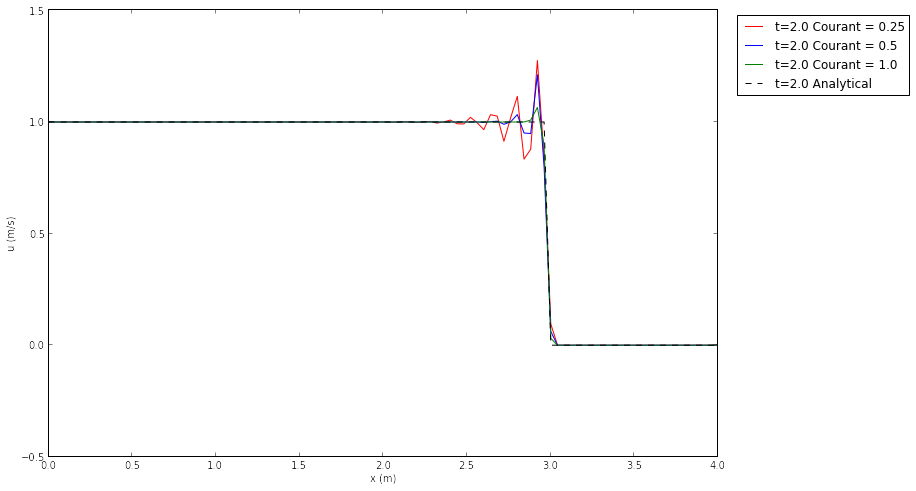

In [195]:
lax_wendroff_convection_cfl(0.25, 0.5, 1.0, 101, 2.0, 4.0)

## Conclusion from Lax-Wendroff

Stability condition:

$$ \left| {\Delta t \over \Delta x} u_{max} \right| \lt 1 $$

Where $ u_{max} $ is the maximum eigenvalue of the A matrix

Lax-Wendroff shows **dispersive errors** $\epsilon_{\phi}$ and very little **diffusion errors** $ \epsilon_D$ and this is because LW is second order:

* When the leading error term is even ordered (as for first order methods), there will be mainly dissipation error
* When the leading error term is odd ordered (as for second order methods), there will be mainly dispersion error

Dispersion error depends on:

* The dispersive errors depend on the wave content of the solution
* Numerical velocity here is lagging
* Oscillations are larger for smaller CFL number - this is the accumulation of numerical dispersion errors




# Design Algorithm to Solve Problem using MacCormack Scheme

Lax-Wendroff is ok, but it was quite complex to code, **Because of the need to compute second order derivatives**. MacCormack should be easier

## Space-time discretisation:

* i $\rightarrow$ index of grid in x
* n $\rightarrow$ index of time

## Conservative Form

$$ {\partial u \over \partial t} + {\partial \over {\partial x}}{ \left( {u^2 \over 2} \right)} = 0 \qquad
   \Leftrightarrow \qquad {\partial u \over \partial t} + {{\partial F} \over {\partial x}} = 0$$

## MacCormack Numerical scheme

* Define predicted terms as $ \tilde{u} $ and $ F(\tilde{u}) = \tilde{F}  $

* Predictor step **FTFS** from $n$ to $n+1$

$$ {{ \tilde{u}_i^{n+1} - u_i^n } \over {\Delta t}} = -\left( {{F_{i+1}^n - F_i^n} \over {\Delta x}} \right) $$

$$ \tilde{u}_i^{n+1} = u_i^n - \Delta t \left( {{F_{i+1}^n - F_{i}^n} \over {\Delta x}}  \right) $$

$$ \tilde{u}_i^{n+1} = u_i^n - \sigma \left( {{F_{i+1}^n - F_{i}^n}}  \right) $$

* Corrector step **FTBS** from $n+{1 \over 2}$ to $n+1$ using predicted values for time $n+1$ and where the midpoint time is the average of the predicted and current values $ u_i^{n+{1 \over 2}} = {1 \over 2} \left( \tilde{u}_i^{n+1} + u_i^n \right) $

$$ {{ u_i^{n+1} - {1 \over 2} \left( \tilde{u}_i^{n+1} + u_i^n \right)} \over {{\Delta t \over 2}}} = -\left( {{\tilde{F}_{i}^{n+1} - \tilde{F}_{i-1}^{n+1}} \over {\Delta x}} \right)$$

$$ u_i^{n+1} = {1 \over 2} \left( \tilde{u}_i^{n+1} + u_i^n \right) - {\Delta t \over 2} \left( {{\tilde{F}_{i}^{n+1} - \tilde{F}_{i-1}^{n+1}} \over {\Delta x}} \right) $$

$$ u_i^{n+1} = {1 \over 2} \left( \tilde{u}_i^{n+1} + u_i^n \right) - {\sigma \over 2} \left( {{\tilde{F}_{i}^{n+1} - \tilde{F}_{i-1}^{n+1}}} \right) $$

## Pseudo-code

       #Constants
       xmax = 4.0
       nx = 51
       dx = xmax/(nx-1)
       tmax = 1.0
       sigma = 1.0
       dt =  dx * sigma
       nt = int(tmax/dt + 1)
       
       #Boundary Conditions
       for n between 0 and nt-1
          u(0,n)=1
          u(nx-1,n)=0 

       #Initial Conditions
       for i between 1 and nx-2
          if(i < (nx-1)/2)
              u(i,0) = 1
          else
              u(i,0) = 0
       
       F = (u/2)**2
       
       #Iteration
       for n between 0 and nt-1
          for i between 1 and nx-2
              up[i,n+1] = u[i,n] - sigma*(F[i+1,n] - F[i,n])
          
              u[i,n+1] = 0.5*(up[i,n+1] + u[i,n]) - 0.5*sigma * (Fp[i,n+1] - Fp[i-1,n+1])

In [197]:
def maccormack_convection_2(sigma, nx, nt, xmax, step):
    """
    Returns the velocity field and distance for 1D linear convection
    """

    # Increments
    dx = xmax/(nx-1)
    dt =  dx * sigma
    nt = int(tmax/dt + 1)

    # Initial and Boundary Conditions
    u = initial_and_boundary_conditions(nx, nt)
    up = initial_and_boundary_conditions(nx, nt)
    
    # X Loop
    x = np.zeros(nx)
    x = np.linspace(0.0,xmax,nx)

    # Lambda function for Flux:
    F = lambda u: u**2.0 / 2.0  
    
    i = 1
    # Loop - must loop as NumPy cannot be used for dependency reasons
    for n in range(0,nt-1):
        up[i:nx-1, n+1] = u[i:nx-1, n] - sigma*(F(u[i+1:nx, n]) - F(u[i:nx-1, n]))
        u[i:nx-1, n+1] = ( 0.5*(up[i:nx-1, n+1] + u[i:nx-1, n]) - 
                           0.5*sigma*(F(up[i:nx-1, n+1]) - F(up[i-1:nx-2, n+1])) )

    # Wave propagating with speed 0.5
    u_lf, x_lf, nt_lf = analytical(nx, tmax, xmax)

    dt_lf = dx * 2.0

    plot(u,x,nt,u_lf, x_lf, nt_lf, step, dt, dt_lf)

In [201]:
def plot_schemes(x,u_1,nt_1,u_2,nt_2,u_3,nt_3,u_lf, x_lf, nt_lf, dt_1, dt_2, dt_3, dt_lf):
      """
      Plots the 1D velocity field
      """

      import matplotlib.pyplot as plt
      import matplotlib.cm as cm
      plt.figure()
      ax=plt.subplot(111)
      c_1 = dt_1/(max(x)/100)
      c_2 = dt_2/(max(x)/100)
      c_3 = dt_3/(max(x)/100)
      t_1 =(nt_1-1)*dt_1      
      ax.plot(x,u_1[:,nt_1-1],linestyle='-',c='r',label='t='+str(t_1)+'Lax-Friedrichs')
      t_2 =(nt_2-1)*dt_2      
      ax.plot(x,u_2[:,nt_2-1],linestyle='-',c='b',label='t='+str(t_2)+'Lax-Wendroff')
      t_3 =(nt_3-1)*dt_3      
      ax.plot(x,u_3[:,nt_3-1],linestyle='-',c='g',label='t='+str(t_3)+'MacCormack')   
            
      t_lf =(nt_lf-1)*dt_lf      
      ax.plot(x_lf,u_lf[:,nt_lf-1],linestyle='--',c='k',label='t='+str(t_lf)+' Analytical')   
      box=ax.get_position()
      ax.set_position([box.x0, box.y0, box.width*2,box.height*2])
      ax.legend( bbox_to_anchor=(1.02,1), loc=2)
      plt.ylim([-0.5,1.5])
      plt.xlim([0.0,4.0])
      plt.xlabel('x (m)')
      plt.ylabel('u (m/s)')
      plt.show()

In [202]:
def maccormack_convection_cfl(sigma_1, sigma_2, sigma_3, nx, tmax, xmax):
    """
    Returns the velocity field and distance for 1D linear convection
    """
    # Increments
    dx = xmax/(nx-1)
    dt_1 =  dx * sigma_1
    nt_1 = int(tmax/dt_1 + 1)
    dt_2 =  dx * sigma_2
    nt_2 = int(tmax/dt_2 + 1)
    dt_3 =  dx * sigma_3
    nt_3 = int(tmax/dt_3 + 1)
    
    # Initial and Boundary Conditions
    u_1 = initial_and_boundary_conditions(nx, nt_1)
    u_2 = initial_and_boundary_conditions(nx, nt_2)
    u_3 = initial_and_boundary_conditions(nx, nt_3)
    up_1 = initial_and_boundary_conditions(nx, nt_1)
    up_2 = initial_and_boundary_conditions(nx, nt_2)
    up_3 = initial_and_boundary_conditions(nx, nt_3)
    
    # X Loop
    x = np.zeros(nx)
    x = np.linspace(0.0,xmax,nx)

    # Lambda function for Flux:
    F = lambda u: u**2.0 / 2.0 
    
    # Lamba function for Jacobian:
    A = lambda u: u
    
    i = 1
    # Loop - must loop as NumPy cannot be used for dependency reasons
    for n in range(0,nt_1-1):
        up_1[i:nx-1, n+1] = u_1[i:nx-1, n] - sigma_1*(F(u_1[i+1:nx, n]) - F(u_1[i:nx-1, n]))
        u_1[i:nx-1, n+1] = ( 0.5*(up_1[i:nx-1, n+1] + u_1[i:nx-1, n]) - 
                           0.5*sigma_1*(F(up_1[i:nx-1, n+1]) - F(up_1[i-1:nx-2, n+1])) )
     
    # Loop - must loop as NumPy cannot be used for dependency reasons
    for n in range(0,nt_2-1):
        up_2[i:nx-1, n+1] = u_2[i:nx-1, n] - sigma_2*(F(u_2[i+1:nx, n]) - F(u_2[i:nx-1, n]))
        u_2[i:nx-1, n+1] = ( 0.5*(up_2[i:nx-1, n+1] + u_2[i:nx-1, n]) - 
                           0.5*sigma_2*(F(up_2[i:nx-1, n+1]) - F(up_2[i-1:nx-2, n+1])) )   
    
    # Loop - must loop as NumPy cannot be used for dependency reasons
    for n in range(0,nt_3-1):
        up_3[i:nx-1, n+1] = u_3[i:nx-1, n] - sigma_3*(F(u_3[i+1:nx, n]) - F(u_3[i:nx-1, n]))
        u_3[i:nx-1, n+1] = ( 0.5*(up_3[i:nx-1, n+1] + u_3[i:nx-1, n]) - 
                           0.5*sigma_3*(F(up_3[i:nx-1, n+1]) - F(up_3[i-1:nx-2, n+1])) )
        
    # Wave at speed 0.5
    u_lf, x_lf, nt_lf = analytical(nx, tmax, xmax)
    
    dt_lf = dx * 2.0
    
    plot_cfl(x,u_1,nt_1,u_2,nt_2,u_3,nt_3,u_lf, x_lf, nt_lf, dt_1, dt_2, dt_3, dt_lf)    

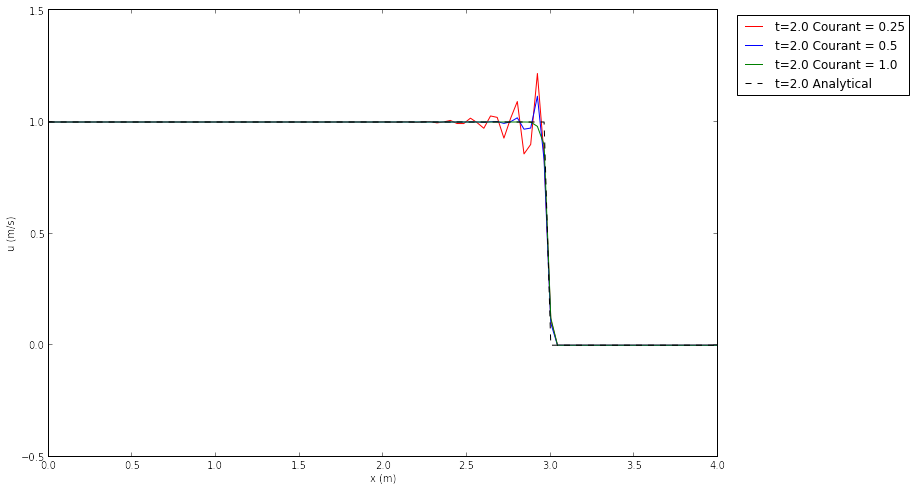

In [203]:
maccormack_convection_cfl(0.25, 0.5, 1.0, 101, 2.0, 4.0)

## Conclusion from MacCormack Scheme

$$ \left| {\Delta t \over \Delta x} u_{max} \right| \lt 1 $$

Similar behaviour to the Lax-Wendroff Scheme i.e.

**The higher the CFL number, the more dispersive errors are accumulated**

However, MacCormack is much easier to program

If dispersion errors caused oscillations - the overshoot may make the solution more unstable

# Which scheme is the best for CFL = 1?

In [208]:
def scheme_comparison(sigma, nx, tmax, xmax):
    """
    Returns the velocity field and distance for 1D linear convection
    """
    # Increments
    dx = xmax/(nx-1)
    dt =  dx * sigma
    nt = int(tmax/dt + 1)
    
    # Initial and Boundary Conditions
    u_1 = initial_and_boundary_conditions(nx, nt)
    u_2 = initial_and_boundary_conditions(nx, nt)
    u_3 = initial_and_boundary_conditions(nx, nt)
    up_3 = initial_and_boundary_conditions(nx, nt)
    
    # X Loop
    x = np.zeros(nx)
    x = np.linspace(0.0,xmax,nx)

    # Lambda function for Flux:
    F = lambda u: u**2.0 / 2.0 
    
    # Lamba function for Jacobian:
    A = lambda u: u
    
    i = 1
    # Lax-Friedrichs
    for n in range(0,nt-1):
        u_1[i:nx-1, n+1] = (0.5*(u_1[i-1:nx-2, n]+u_1[i+1:nx, n])-
                         0.5*sigma*(F(u_1[i+1:nx, n])-F(u_1[i-1:nx-2, n])))
     
    # Lax-Wendroff
    for n in range(0,nt-1):
        u_2[i:nx-1, n+1] = (u_2[i:nx-1,n] -
                         0.5*sigma*( F(u_2[i+1:nx, n])-F(u_2[i-1:nx-2, n]) ) + 
        0.25*(sigma**2)*( ( A(u_2[i+1:nx, n])+A(u_2[i:nx-1, n]) )*
                          ( F(u_2[i+1:nx, n])-F(u_2[i:nx-1, n]) )-
                          ( A(u_2[i:nx-1, n])+A(u_2[i-1:nx-2, n]) )*
                          ( F(u_2[i:nx-1, n])-F(u_2[i-1:nx-2, n]) ) ) )   
    
    # MacCormack
    for n in range(0,nt-1):
        up_3[i:nx-1, n+1] = u_3[i:nx-1, n] - sigma*(F(u_3[i+1:nx, n]) - F(u_3[i:nx-1, n]))
        u_3[i:nx-1, n+1] = ( 0.5*(up_3[i:nx-1, n+1] + u_3[i:nx-1, n]) - 
                           0.5*sigma*(F(up_3[i:nx-1, n+1]) - F(up_3[i-1:nx-2, n+1])) )
        
    # Wave at speed 0.5
    u_lf, x_lf, nt_lf = analytical(nx, tmax, xmax)
    
    dt_lf = dx * 2.0
    
    plot_schemes(x,u_1,nt,u_2,nt,u_3,nt,u_lf, x_lf, nt_lf, dt, dt, dt, dt_lf)  

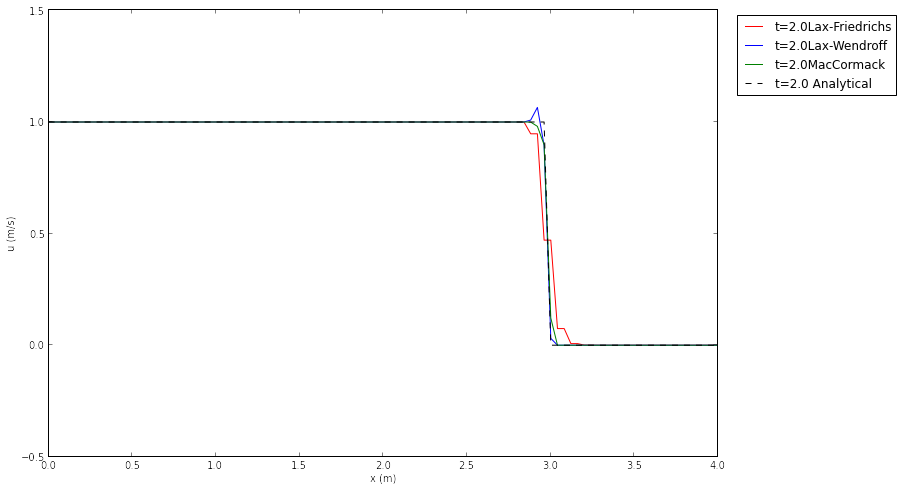

In [209]:
scheme_comparison(1.0, 101, 2.0, 4.0)

### Conclusion of the Best Scheme

MacCormack is the best scheme:

* less diffusive than Lax-Freidrichs 
* less dispersive than Lax-Wendroff 

# Design Algorithm to Solve Problem using Beam-Warming Scheme

## Space-time discretisation:

* i $\rightarrow$ index of grid in x
* n $\rightarrow$ index of time

## Beam-Warming Numerical scheme

* Taylor Expansion to 2nd order term (replacing $ u_t $ with the average):

$$ u_i^{n+1} = u_i^n + {\Delta t \over 2}[(u_t)_i^n + (u_t)_i^{n+1}] + O(\Delta t^3) $$

* Replace $u_t$ by spatial derivatives:

$$ (u_t)_i^n = - (F_x)_i^n $$

$$ u_i^{n+1} = u_i^n - {\Delta t \over 2}[(F_x)_i^n + (F_x)_i^{n+1}] $$

* Taylor Expansion of $F^{n+1}$

$$ F^{n+1} = F^n + {{\partial F \over \partial t} \Delta t} + O(\Delta t^2) $$

* Replacing the derivative of F with the Jacobian and using **Forward Differencing in time for the velocity gradient** (to avoid a second order derivative in space for F):

$$ {{\partial F} \over {\partial t}} = {{\partial F} \over {\partial u}} {{\partial u} \over {\partial t}} = A_i^n {{\left( {{u_i^{n+1} - u_i^n}} \right)} \over \Delta t} $$

Hence:

$$ F_i^{n+1} = F_i^n + {{A_i^n u_i^{n+1} - A_i^n u_i^n} \over \Delta t} $$

And:

$$ u_i^{n+1} = u_i^n - {\Delta t \over 2}[2(F_x)_i^n + {\partial \over {\partial x}} \left( {A_i^n u_i^{n+1} - A_i^n u_i^n} \right)] $$

* For the first derivative of **Flux** in space: 2nd order CD in space between `i+1` and `i-1`
* For the first derivative of **Jacobian times the Velocity Difference** in space: 2nd order in space between `i+1` and `i-1`

## Discrete equation

$$ u_i^{n+1} = u_i^n - {{\Delta t \over 2}} {(F_{i+1}^n - F_{i-1}^n) \over {\Delta x}} - {{\Delta t} \over 2} {({A_{i+1}^n u_{i+1}^{n+1} - A_{i-1}^n u_{i-1}^{n+1}}) \over {2 \Delta x}} -{{\Delta t} \over 2} {({A_{i+1}^n u_{i+1}^n - A_{i-1}^n u_{i-1}^n}) \over {2 \Delta x}} $$

$$ - {\Delta t \over {4 \Delta x}} \left( A_{i-1}^n u_{i-1}^{n+1} \right) + 
u_i^{n+1} + {\Delta t \over {4 \Delta x}} \left( A_{i+1}^n u_{i+1}^{n+1} \right) = 
u_i^n - {1 \over 2} {\Delta t \over \Delta x} (F_{i+1}^n - F_{i-1}^n) + 
{\Delta t \over 4 \Delta x}(A_{i+1}^n u_{i+1}^n - A_{i-1}^n u_{i-1}^n) $$

## TDMA

For a description of this, see:

http://www.thevisualroom.com/tri_diagonal_matrix.html

## Pseudo-code

       #Constants
       xmax = 4.0
       nx = 101
       dx = xmax/(nx-1)
       tmax = 2.0
       sigma = 1.0
       dt =  dx * sigma
       nt = int(tmax/dt + 1)
       
       #Boundary Conditions
       for n between 0 and nt-1
          u[0,n]=1
          u[nx-1,n]=0 

       #Initial Conditions
       for i between 1 and nx-2
          if(i < (nx-1)/2)
              u[i,0] = 1
          else
              u[i,0] = 0
       
       #Lambda function
       F = (u/2)**2
       
       #Lamba function
       A = u
              
       #Iteration
       for n between 0 and nt-1
           for i between 1 and nx-2  
          
               a[i] = - (dt / (4 * dx)) * A[i-1, n]

               b[i] = 1

               c[i] = (dt / (4 * dx)) * A[i+1, n]

               d[i] =  u[i,n] - 0.5 * (dt / dx) * (F[i+1, n] - F[i-1, n]) + 
                  (dt / (4 * dx)) * (A[i+1, n] * u[i+1, n] - A[i-1, n] * u[i-1, n])
                  
               #Corrections for BCs:
              
               d[1] = d[1]-a[1]*B1
               d[nx-2] = d[nx-2]-a[nx-2]*B2
             
               #Built-in solver:
               
               l_and_u = (1, 1)
               abc = np.matrix([c[1:nx-1], b[1:nx-1], a[1:nx-1])
               RHS = d[1:nx-1]
               u[1:nx-1, n] = linalg.solve_banded(l_and_u, abc, RHS)
                

In [213]:
try:
    import numpypy as np # for compatibility with numpy in pypy
except:
    import numpy as np # if using numpy in cpython
 
## Tri Diagonal Matrix Algorithm(a.k.a Thomas algorithm) solver
def TDMAsolver(a, b, c, d):
    '''
    TDMA solver, a b c d can be NumPy array type or Python list type.
    refer to http://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm
    '''
    nf = len(a) # number of equations
    ac, bc, cc, dc = map(np.array, (a, b, c, d)) # copy the array
    for it in xrange(1, nf):
        mc = ac[it]/bc[it-1]
        bc[it] = bc[it] - mc*cc[it-1]
        dc[it] = dc[it] - mc*dc[it-1]

    xc = ac
    xc[-1] = dc[-1]/bc[-1]

    for il in xrange(nf-2, -1, -1):
        xc[il] = (dc[il]-cc[il]*xc[il+1])/bc[il]

    del bc, cc, dc # delete variables from memory

    return xc 

In [249]:
def plot_oscillatory(u,x,NT,u_analytical, x_analytical, NT2, step, dt, dt_lf):
      """
      Plots the 1D velocity field
      """

      import matplotlib.pyplot as plt
      import matplotlib.cm as cm
      plt.figure()
      ax=plt.subplot(111)
      colour=iter(cm.rainbow(np.linspace(0,step,NT)))   
      for n in range(0,int(NT),int(step)):
         t = n*dt
         c=next(colour)
         ax.plot(x,u[:,n],linestyle='-',c=c,label='t='+str(t))
      t_lf =(NT2-1)*dt_lf      
      ax.plot(x_analytical,u_analytical[:,NT2-1],linestyle='--',c='k',label='t='+str(t_lf)+' analytical')   
      box=ax.get_position()
      ax.set_position([box.x0, box.y0, box.width*2,box.height*2])
      ax.legend( bbox_to_anchor=(1.02,1), loc=2)
      plt.ylim([-0.2,1.8])
      plt.xlim([0.0,4.0])
      plt.xlabel('x (m)')
      plt.ylabel('u (m/s)')
      plt.show()

In [260]:
def beam_warming_convection(sigma, nx, tmax, xmax, step, B1):
    
    from scipy import linalg
    
    """
    Returns the velocity field and distance for 1D linear convection
    """
    # Increments
    dx = xmax/(nx-1)
    dt =  dx * sigma
    nt = int(tmax/dt + 1)
    
    # Initial and Boundary Conditions
    u = initial_and_boundary_conditions(nx, nt)
    
    # X Loop
    x = np.zeros(nx)
    x = np.linspace(0.0,xmax,nx)

    # Coefficients
    a = np.zeros(nx-2)
    b = np.ones(nx-2)
    c = np.zeros(nx-2)
    d = np.zeros(nx-2)
    
    # Lambda function for Flux:
    F = lambda u: u**2.0 / 2.0 
    
    # Lambda function for Jacobian:
    A = lambda u: u
    
    # index of space
    i = 1
    
    #index in TDMA
    m = 0
    
    # Loop - must loop as NumPy cannot be used for dependency reasons
    for n in range(0,nt-1):
        
        a[m:nx-2] = - (dt / (4.0 * dx)) * A(u[i-1:nx-2, n])
        
        b[m:nx-2] = 1.0
        
        c[m:nx-2] = (dt / (4.0 * dx)) * A(u[i+1:nx, n])
        
        d[m:nx-2] = ( u[i:nx-1,n] - 
                      0.5 * (dt / dx) * (F(u[i+1:nx, n]) - F(u[i-1:nx-2, n])) + 
                      (dt / (4.0 * dx)) * (A(u[i+1:nx, n]) * u[i+1:nx, n] - 
                                           A(u[i-1:nx-2, n]) * u[i-1:nx-2, n]) )
        #Correction for BCs (other BCs = 0):
        d[m] = ( u[i,n] - 
                      0.5 * (dt / dx) * (F(u[i+1, n]) - F(u[i-1, n])) + 
                      (dt / (4.0 * dx)) * (A(u[i+1, n]) * u[i+1, n] - 
                                           A(u[i-1, n]) * u[i-1, n]) - a[m]*B1 )
        
        u[1:nx-1, n+1] = TDMAsolver(a, b, c, d)

        
    # Wave at speed 0.5
    u_lf, x_lf, nt_lf = analytical(nx, tmax, xmax)

    dt_lf = dx * 2.0

    plot_oscillatory(u,x,nt,u_lf, x_lf, nt_lf, step, dt, dt_lf) 

## Beam-Warming with CFL = 1

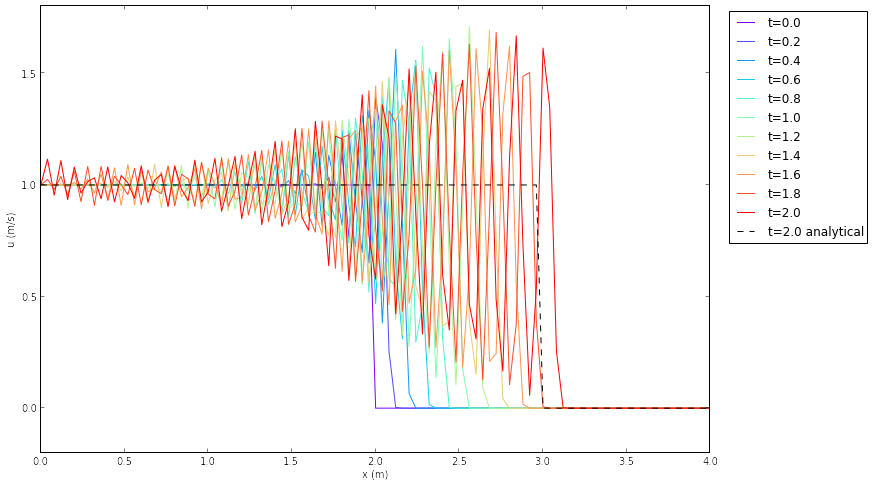

In [268]:
beam_warming_convection(1.0, 101, 2.0, 4.0, 5, 1.0)

## What happens if the grid density is increased?

* Oscillation density increases
* Scheme is still stable, but oscillatory

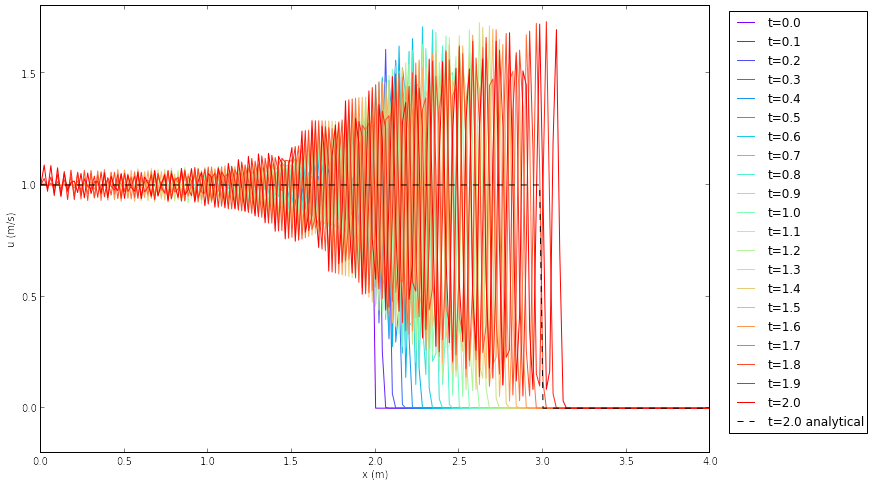

In [300]:
beam_warming_convection(1.0, 201, 2.0, 4.0, 5, 1.0)

## Conclusions from Beam-Warming

The method is stable but oscillatory because of the absense of damping, so introduce a damping function onto the RHS:

$$ D_e = - \epsilon_e(u_{i+2}^n - 4u_{i+1}^n + 6u_i^n - 4u_{i-1}^n + u_{i-2}^n) $$

For the **solution point** $i=1$, the value of $u_{-1}$ is unknown, so set it to the value at $u_{0}$ (as no periodic boundaries are used).

For the **solution point** $i=nx-2$ the value of $u_{nx}$ is unknown, so set it to the value at $u_{nx-1}$ (for the same reason)


## Pseudo Code

       #Constants
       epsilon = 0.125

       for i between 1 and nx-2
           ipos[i]=i+2
           ineg[i]=i-2

       ipos[nx-2]=nx-1
       ineg[1]=0
       
       for i between 1 and nx-2
           
           D[i] = -epsilon*(u[ipos[i],n] - 4*u[i+1,n] + 6*u[i,n] - 4*u[i-1,n] + u[ineg[i],n])
           
           # D[i] = -epsilon*(u[i+2,n] - 4*u[i+1,n] + 6*u[i,n] - 4*u[i-1,n] + u[i-2,n])

In [244]:
def damping_function(u, epsilon, nx, n):
    
    ipos = np.zeros(nx, dtype=numpy.int)
    ineg = np.zeros(nx, dtype=numpy.int)
    
    for i in range(1,nx-1):
        ipos[i] = i+2
        ineg[i] = i-2
    
    # Set the values at the extremities to the boundary values    
    ipos[nx-2] = nx-1
    ineg[1] = 0
    
    D = np.zeros(nx)
    i = 1
    D[i:nx-1] = epsilon * (u[ipos[i:nx-1],n] - 4*u[i+1:nx,n] +
                         6*u[i:nx-1,n] - 4*u[i-1:nx-2,n] + u[ineg[i:nx-1],n])
    
    return D

In [295]:
def beam_warming_convection_damping(sigma, nx, tmax, xmax, step, B1, epsilon):
    
    from scipy import linalg
    
    """
    Returns the velocity field and distance for 1D linear convection
    """
    # Increments
    dx = xmax/(nx-1)
    dt =  dx * sigma
    nt = int(tmax/dt + 1)
    
    # Initial and Boundary Conditions
    u = initial_and_boundary_conditions(nx, nt)
    
    # X Loop
    x = np.zeros(nx)
    x = np.linspace(0.0,xmax,nx)

    # Coefficients
    a = np.zeros(nx-2)
    b = np.ones(nx-2)
    c = np.zeros(nx-2)
    d = np.zeros(nx-2)
    
    # Lambda function for Flux:
    F = lambda u: u**2.0 / 2.0 
    
    # Lambda function for Jacobian:
    A = lambda u: u
    
    # index of space
    i = 1
    
    #index in TDMA
    m = 0
    
    # Loop - must loop as NumPy cannot be used for dependency reasons
    for n in range(0,nt-1):
        
        D = damping_function(u, epsilon, nx, n)
        
        a[m:nx-2] = - (dt / (4.0 * dx)) * A(u[i-1:nx-2, n])
        
        b[m:nx-2] = 1.0
        
        c[m:nx-2] = (dt / (4.0 * dx)) * A(u[i+1:nx, n])
        
        d[m:nx-2] = ( u[i:nx-1,n] - 
                      0.5 * (dt / dx) * (F(u[i+1:nx, n]) - F(u[i-1:nx-2, n])) + 
                      (dt / (4.0 * dx)) * (A(u[i+1:nx, n]) * u[i+1:nx, n] - 
                                           A(u[i-1:nx-2, n]) * u[i-1:nx-2, n]) - D[i:nx-1] )
        #Correction for BCs (other BCs = 0):
        d[m] = ( u[i,n] - 
                      0.5 * (dt / dx) * (F(u[i+1, n]) - F(u[i-1, n])) + 
                      (dt / (4.0 * dx)) * (A(u[i+1, n]) * u[i+1, n] - 
                                           A(u[i-1, n]) * u[i-1, n]) - D[i] - a[m]*B1 )
        
        u[1:nx-1, n+1] = TDMAsolver(a, b, c, d)

        
    # Wave at speed 0.5
    u_lf, x_lf, nt_lf = analytical(nx, tmax, xmax)

    dt_lf = dx * 2.0

    plot_oscillatory(u,x,nt,u_lf, x_lf, nt_lf, step, dt, dt_lf) 


## What is the effect of damping?

* Damping reduces the oscillatory response, although the scheme is implicitly stable

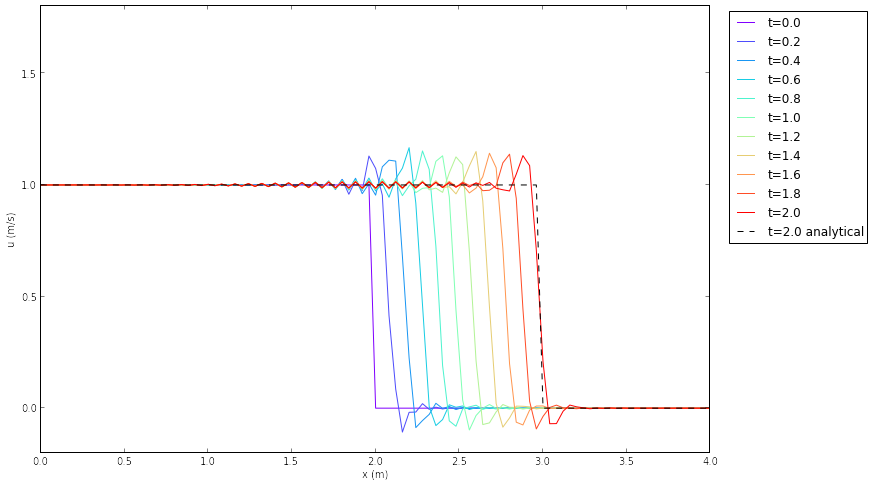

In [303]:
beam_warming_convection_damping(0.5, 101, 2.0, 4.0, 10, 1.0, 0.125)

## What happens if the BC on the LHS is set to zero?
* Solution is invalid

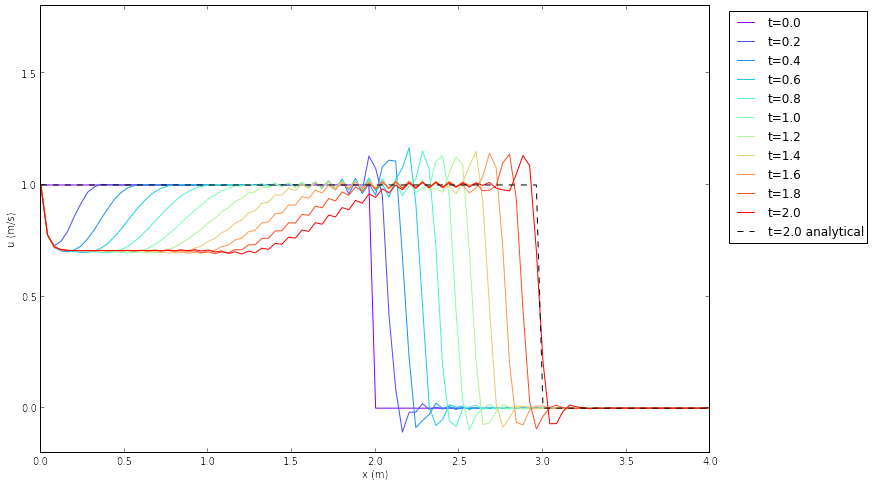

In [298]:
beam_warming_convection_damping(0.5, 101, 2.0, 4.0, 10, 0.0, 0.125)